In [1]:
ownerpath = f'/Users/mia/Desktop/AST443 Observational Techniques in Astronomy'

In [2]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Spectra Dark Frames

In [3]:
#Open the darks files and grab the data
raw_darks_120=[]

for i in range(5):
    dark_file=f'{ownerpath}/Lab 3/20tau/darks/darks_120s_.0000000{i}.DARK.FIT'
    dark_file_data=fits.open(dark_file)
    raw_darks_120.append(dark_file_data[0].data)

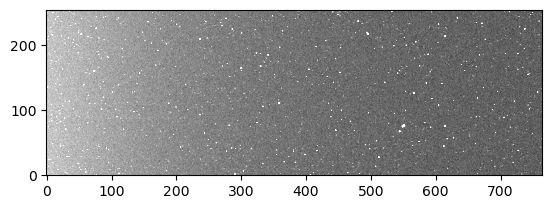

In [4]:
plt.imshow(raw_darks_120[2], vmin=np.mean(raw_darks_120[2])-np.std(raw_darks_120[2]),vmax=np.mean(raw_darks_120[2])+np.std(raw_darks_120[2]), cmap='gray', origin='lower')

# Master Dark Frame

In [5]:
#Average the dark frames to create the master dark
master_dark = np.median(raw_darks_120, axis=0)

# Spectra Flat Fields

In [6]:
#Open the flat field files and grab the data
raw_flats_120=[]

for i in range(5):
    flat_file=f'{ownerpath}/Lab 3/20tau/flats/flats_120s_.0000000{i}.FLAT.FIT'
    flat_file_data=fits.open(flat_file)
    raw_flats_120.append(flat_file_data[0].data)

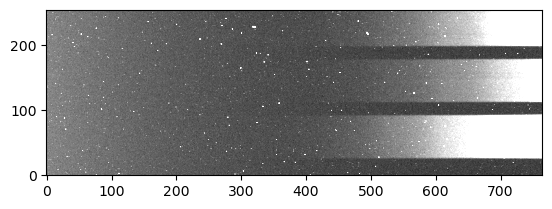

In [7]:
plt.imshow(raw_flats_120[2], vmin=np.mean(raw_flats_120[2])-np.std(raw_flats_120[2]),vmax=np.mean(raw_flats_120[2])+np.std(raw_flats_120[2]), cmap='gray', origin='lower')

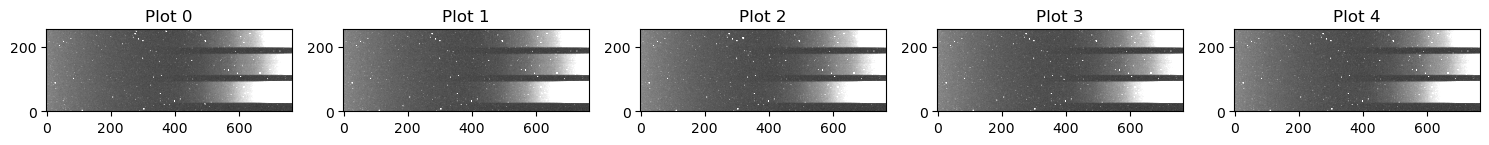

In [8]:
# All 5 Flat Fields
fig, axes = plt.subplots(1, 5, figsize=(15, 25))

# Loop over each subplot and display the images
for i in range(5):
    ax = axes[i]  # Select the appropriate axis
    ax.imshow(raw_flats_120[i],
              vmin=np.mean(raw_flats_120[i]) - np.std(raw_flats_120[i]),
              vmax=np.mean(raw_flats_120[i]) + np.std(raw_flats_120[i]),
              cmap='gray',
              origin='lower')
    ax.set_title(f"Plot {i}")
    #ax.axis('off')  # Optional: Hide axes for a cleaner look

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Master Flat Field (Dark Subtracted and Normalized)

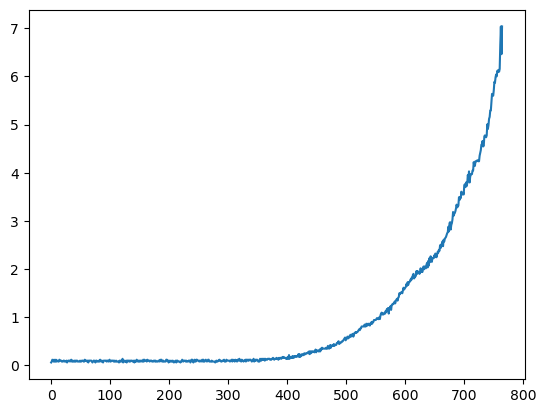

In [9]:
#Average the flat field frames to create the master flat field
master_flat = np.median(raw_flats_120, axis=0)

# Subtract the master dark from the master flat field
flat_dark_subtracted = master_flat - master_dark

# Set negative values to zero (optional)
flat_dark_subtracted[flat_dark_subtracted < 0] = 0

# Normalize
flat_dark_subtracted_normalized = flat_dark_subtracted / np.mean(flat_dark_subtracted)

master_flat_1d = np.median(flat_dark_subtracted_normalized, axis=0)
plt.plot(master_flat_1d)

In [10]:
#example = ([[1,2,3],[4,5,6]])
#example.shape

flat_dark_subtracted_normalized
#flat_dark_subtracted_normalized.shape

array([[0.19181005, 0.        , 0.09590502, ..., 0.03836201, 0.05754301,
        0.07672402],
       [0.        , 0.21099105, 0.47952512, ..., 0.05754301, 0.13426703,
        0.24935306],
       [0.        , 0.        , 0.        , ..., 0.23017206, 0.15344804,
        0.019181  ],
       ...,
       [0.03836201, 0.        , 0.57543014, ..., 9.07261526, 9.39869234,
        9.39869234],
       [0.        , 0.15344804, 0.23017206, ..., 9.14933928, 9.6480454 ,
        9.34114932],
       [0.        , 0.09590502, 0.24935306, ..., 9.55214038, 9.37951133,
        9.66722641]])

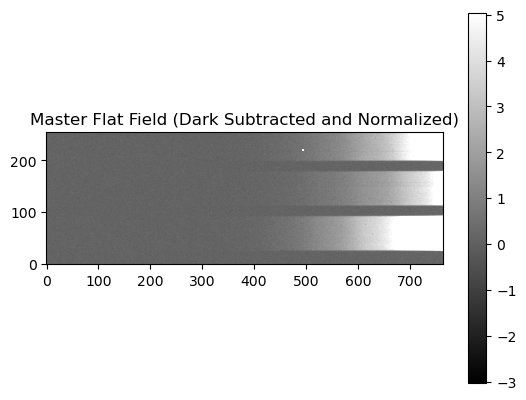

In [11]:
# Set negative values to zero
flat_dark_subtracted_normalized[flat_dark_subtracted_normalized < 0] = 0

# Display the normalized master flat field with darks subtracted using customized color scaling
plt.imshow(flat_dark_subtracted_normalized,
           vmin=np.mean(flat_dark_subtracted_normalized) - (2 * np.std(flat_dark_subtracted_normalized)),
           vmax=np.mean(flat_dark_subtracted_normalized) + (2 * np.std(flat_dark_subtracted_normalized)),
           cmap='gray', origin='lower')

plt.title("Master Flat Field (Dark Subtracted and Normalized)")
plt.colorbar()
plt.show()

# 20 Tau Light Frames

## read data

In [12]:
#Open the 20tau light frame files and extract the data
raw_20tau=[]

for i in range(12):
    if i < 10:
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.0000000{i}.FIT'
#    elif i < 20 :
#        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.000000{i}.FIT'
    tau20_file_data=fits.open(tau20_file)
    raw_20tau.append(tau20_file_data[0].data)

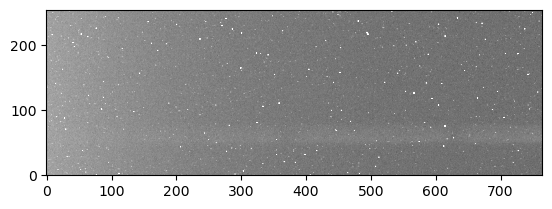

In [13]:
plt.imshow(raw_20tau[2], vmin=np.mean(raw_20tau[2])-(2*np.std(raw_20tau[2])),vmax=np.mean(raw_20tau[2])+(2*np.std(raw_20tau[2])), cmap='gray', origin='lower')

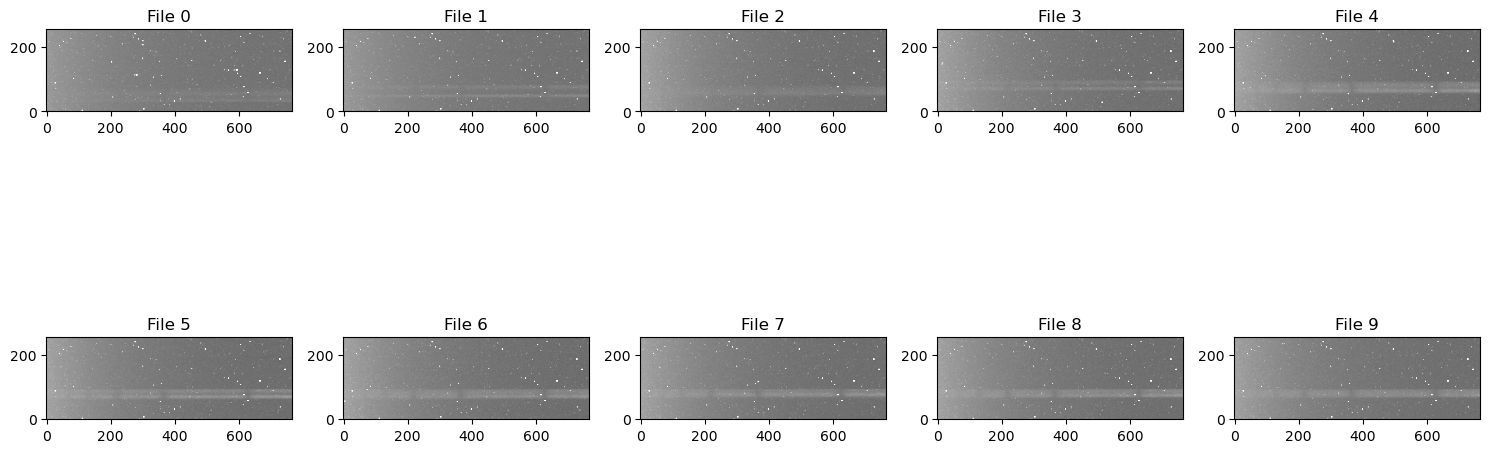

In [14]:
# All 10 light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns

# Loop through each image
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau[i],
            vmin=np.mean(raw_20tau[i]) - (2 * np.std(raw_20tau[i])),
            vmax=np.mean(raw_20tau[i]) + (2 * np.std(raw_20tau[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each plot
        #ax.axis('off')

plt.tight_layout()  # Adjust spacing
plt.show()

## dark subtract

In [15]:
#Subtract the master dark from each light frame (20 Tau light frames)
darksubtracted_20tau = []
for i in range(len(raw_20tau)):
    darksubtracted_frame = raw_20tau[i] - master_dark
    darksubtracted_20tau.append(darksubtracted_frame)

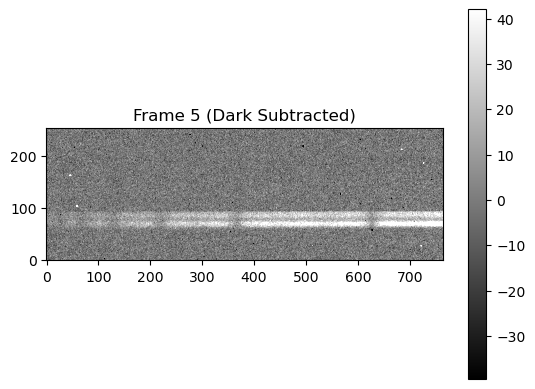

In [16]:
# Display Frame n
frame_index = 5  #Frame 0 to 9

# Display the selected frame with customized color scale
plt.imshow(darksubtracted_20tau[frame_index],
           vmin=np.mean(darksubtracted_20tau[frame_index]) - (2 * np.std(darksubtracted_20tau[frame_index])),
           vmax=np.mean(darksubtracted_20tau[frame_index]) + (2 * np.std(darksubtracted_20tau[frame_index])),
           cmap='gray', origin='lower')

# Add title and labels
plt.title(f"Frame {frame_index} (Dark Subtracted)")
plt.colorbar()  # Optional: Show a color bar

# Show the plot
plt.show()

## flat

In [17]:
# Multiply each dark-subtracted 20 Tau frame by the normalized master flat field
final_20tau = []
for i in range(len(darksubtracted_20tau)):
#    final_frame = darksubtracted_20tau[i] * flat_dark_subtracted_normalized
    final_frame = darksubtracted_20tau[i] / flat_dark_subtracted_normalized
    final_20tau.append(final_frame)

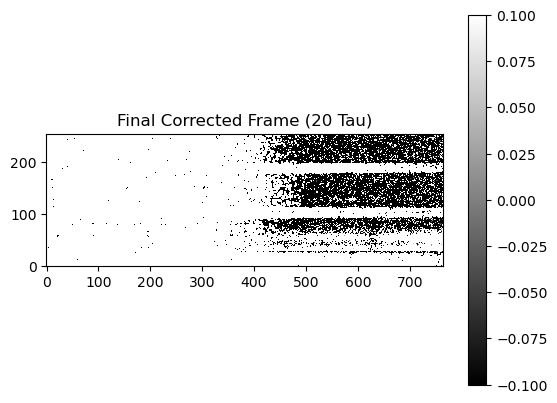

In [18]:
# Display the first final corrected frame (20 Tau)
plt.imshow(final_20tau[0],
           vmin=np.mean(final_20tau[8]) - (1.25 * np.std(final_20tau[8])),
           vmax=np.mean(final_20tau[8]) + (1.25 * np.std(final_20tau[8])),
           cmap='gray', origin='lower')

# Add title and colorbar
plt.title("Final Corrected Frame (20 Tau)")
plt.colorbar()  # Show a color bar

# Show the plot
plt.show()

## cut

In [19]:
#Open the etatau light frame files and extract the data
raw_etatau=[]

for i in range(10):
    taueta_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/etatau_light_120s_.0000000{i}.FIT'
    taueta_file_data=fits.open(taueta_file)
    raw_etatau.append(taueta_file_data[0].data)

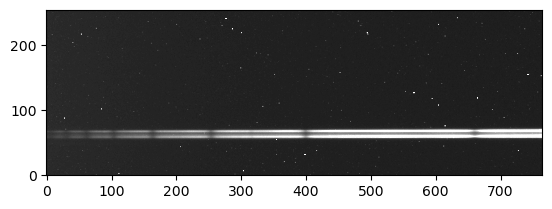

In [20]:
plt.imshow(raw_etatau[2], vmin=np.mean(raw_etatau[2])-np.std(raw_etatau[2]),vmax=np.mean(raw_etatau[2])+(5*np.std(raw_etatau[2])), cmap='gray', origin='lower')

In [21]:
#Open the qtau light frame files and extract the data
raw_qtau=[]

for i in range(10):
    tauq_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/qtau_light_120s_.0000000{i}.FIT'
    tauq_file_data=fits.open(tauq_file)
    raw_qtau.append(tauq_file_data[0].data)

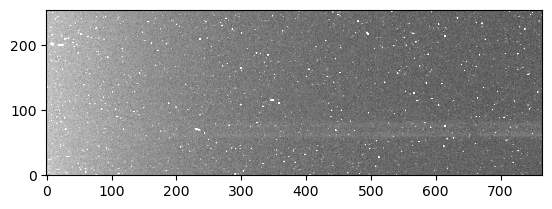

In [22]:
plt.imshow(raw_qtau[2], vmin=np.mean(raw_qtau[2])-(np.std(raw_qtau[2])),vmax=np.mean(raw_qtau[2])+(np.std(raw_qtau[2])), cmap='gray', origin='lower')

In [23]:
#Open the mercury frame files and extract the data
raw_mercury=[]

for i in range(2):
    mercury_file = f'{ownerpath}/Lab 3/20tau/mercury_arc_lamp/mercury_light_120s_.0000000{i}.FIT'
    mercury_file_data=fits.open(mercury_file)
    raw_mercury.append(mercury_file_data[0].data)

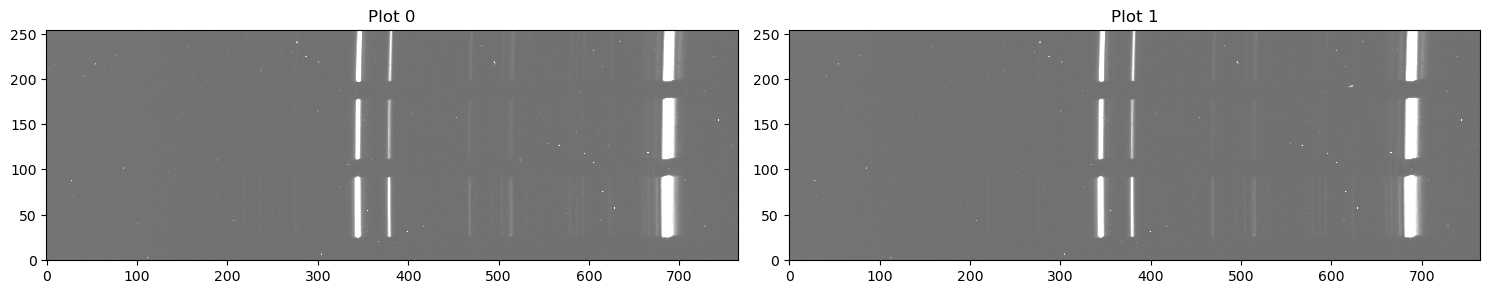

In [24]:
# All mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(2):  # Loop through the 3 indices
    axes[i].imshow(raw_mercury[i],
                   vmin=np.mean(raw_mercury[i]) - np.std(raw_mercury[i]),
                   vmax=np.mean(raw_mercury[i]) + np.std(raw_mercury[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [25]:
# List to hold the cut data of each mercury frame
raw_mercury_cut = []

# Define the y-axis ranges for each frame
y_ranges_raw_hg = [(24, 94), (24, 94)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(2):
    # Get the full frame data
    mercury_data = raw_mercury[i]

    # Cut the frame data along the y-axis according to the specified range
    hgy_start, hgy_end = y_ranges_raw_hg[i]
    cut_mercury_data = mercury_data[hgy_start:hgy_end, :]

    # Append the cut frame data to the list
    raw_mercury_cut.append(cut_mercury_data)

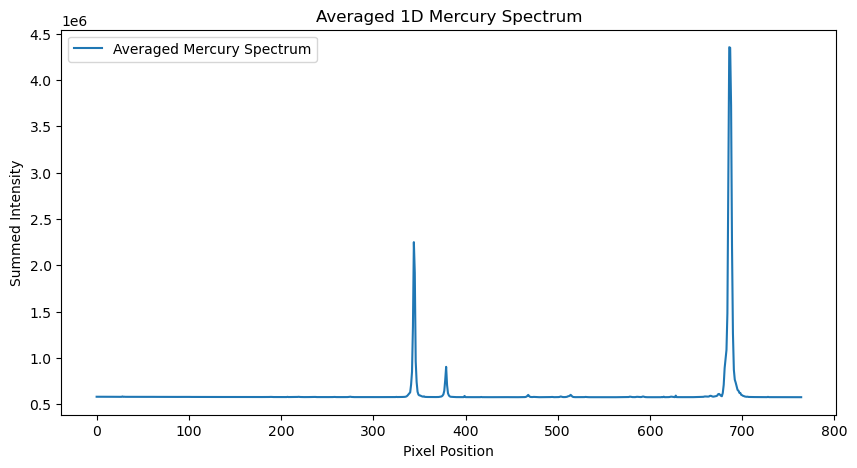

In [26]:
# Step 1: Sum along the y-axis for each mercury frame
summed_mercury = []

for frame in raw_mercury_cut:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_mercury.append(summed_1d)

# Step 2: Average the summed mercury spectra across the frames
average_mercury_spectrum = np.mean(summed_mercury, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(average_mercury_spectrum, label="Averaged Mercury Spectrum")
plt.title("Averaged 1D Mercury Spectrum")
plt.xlabel("Pixel Position")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

In [27]:
#Wavelengths of identified Mercury lines 
#from https://www.newport.com/medias/sys_master/images/images/h55/hfd/8797293281310/Typical-Spectra-of-Spectral-Calib-Lamps.pdf

identified_hg_lines = {
    "Hg 435.86 nm": 435.86,
    "Hg 407.78 nm": 407.78,
    "Hg 404.66 nm": 404.66
}

hg_wavelength=sorted(identified_hg_lines.values())
hg_dict=sorted(identified_hg_lines.keys())

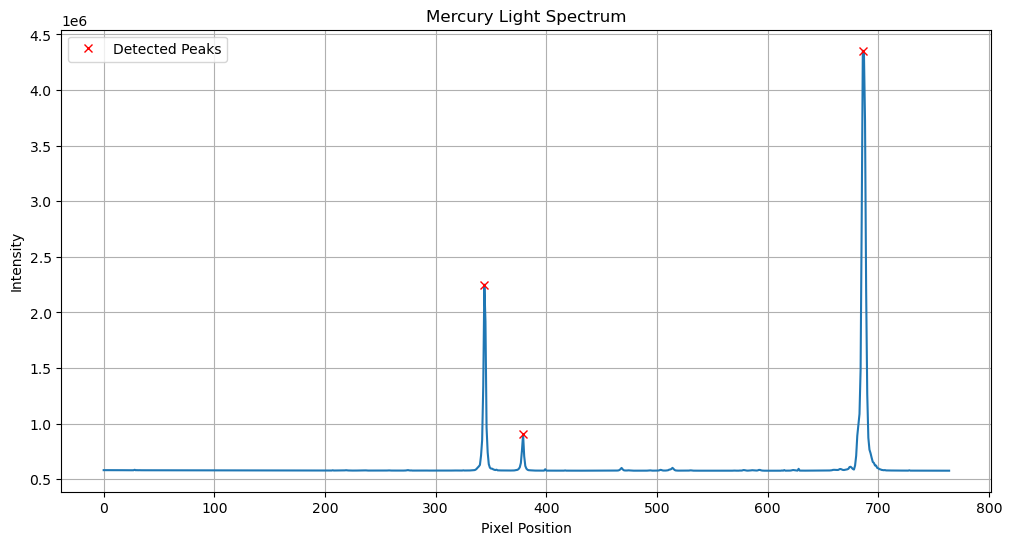

In [28]:
#Finding the peaks of each observed Mercury line

pixel_pos=np.arange(len(average_mercury_spectrum))

peaks, _ = find_peaks(average_mercury_spectrum, prominence=26000)
peak_points= pixel_pos[peaks]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pixel_pos, average_mercury_spectrum)
plt.plot(peak_points, average_mercury_spectrum[peaks], "x", label='Detected Peaks', color='red')
plt.title('Mercury Light Spectrum')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()

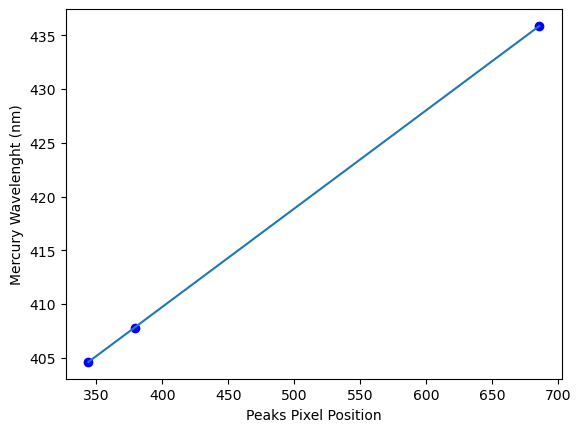

In [29]:
#Finding the pixel to wavelength ratio

w_coef = np.polyfit(peak_points,hg_wavelength,1)
poly1d_w = np.poly1d(w_coef)

plt.plot(peak_points, hg_wavelength, 'bo', peak_points, poly1d_w(peak_points))
plt.xlabel('Peaks Pixel Position')
plt.ylabel('Mercury Wavelenght (nm)')
plt.show()

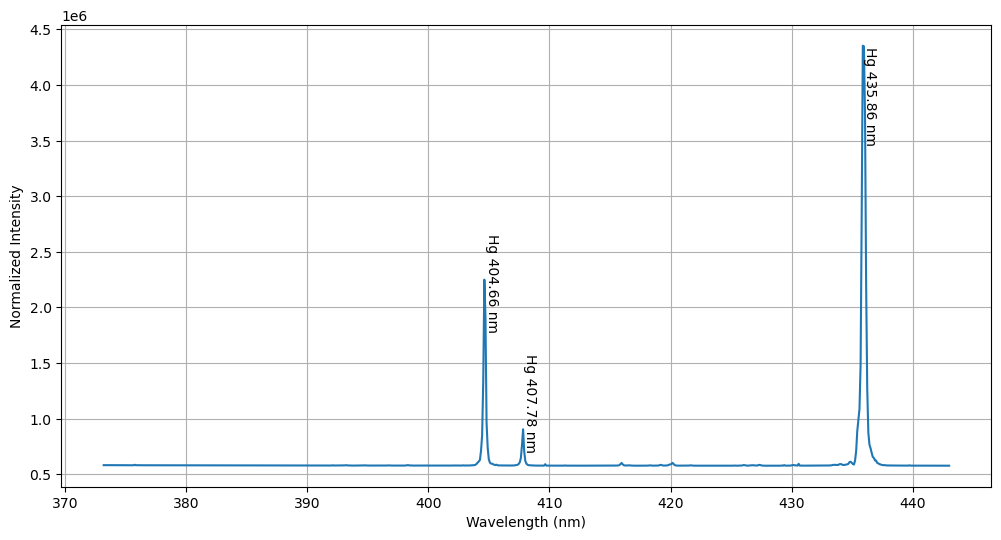

In [30]:
calibrated_wave=(pixel_pos*w_coef[0])+w_coef[1]

plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, average_mercury_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.grid()

# Annotate Neon lines
for i in range(len(hg_wavelength)):
    #plt.axvline(x=n_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(hg_wavelength[i],average_mercury_spectrum[peaks][i]/1.25, hg_dict[i], 
             fontsize=10, rotation=270, color='black', ha='left')

In [31]:
calibrated_wave

array([373.20932846, 373.30064998, 373.39197149, 373.48329301,
       373.57461452, 373.66593604, 373.75725755, 373.84857907,
       373.93990058, 374.0312221 , 374.12254361, 374.21386513,
       374.30518664, 374.39650816, 374.48782967, 374.57915119,
       374.6704727 , 374.76179422, 374.85311573, 374.94443725,
       375.03575876, 375.12708028, 375.21840179, 375.30972331,
       375.40104482, 375.49236634, 375.58368785, 375.67500937,
       375.76633088, 375.8576524 , 375.94897391, 376.04029543,
       376.13161694, 376.22293846, 376.31425997, 376.40558149,
       376.496903  , 376.58822452, 376.67954603, 376.77086755,
       376.86218906, 376.95351058, 377.04483209, 377.13615361,
       377.22747512, 377.31879664, 377.41011815, 377.50143967,
       377.59276118, 377.6840827 , 377.77540421, 377.86672573,
       377.95804724, 378.04936876, 378.14069027, 378.23201179,
       378.3233333 , 378.41465482, 378.50597633, 378.59729785,
       378.68861936, 378.77994088, 378.87126239, 378.96

In [32]:
# List to hold the cut data of each dark frame for 20tau
darks_20tau_cut = []

# Define the y-axis ranges for each frame
dark20_y_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = dark20_y_ranges[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_20tau_cut.append(cut_frame_data)

In [33]:
#Open the 20tau light frame files and extract the data
raw_20tau=[]

for i in range(10):
    if i < 10:
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.0000000{i}.FIT'
    elif i < 20 :
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.000000{i}.FIT'
    tau20_file_data=fits.open(tau20_file)
    raw_20tau.append(tau20_file_data[0].data)

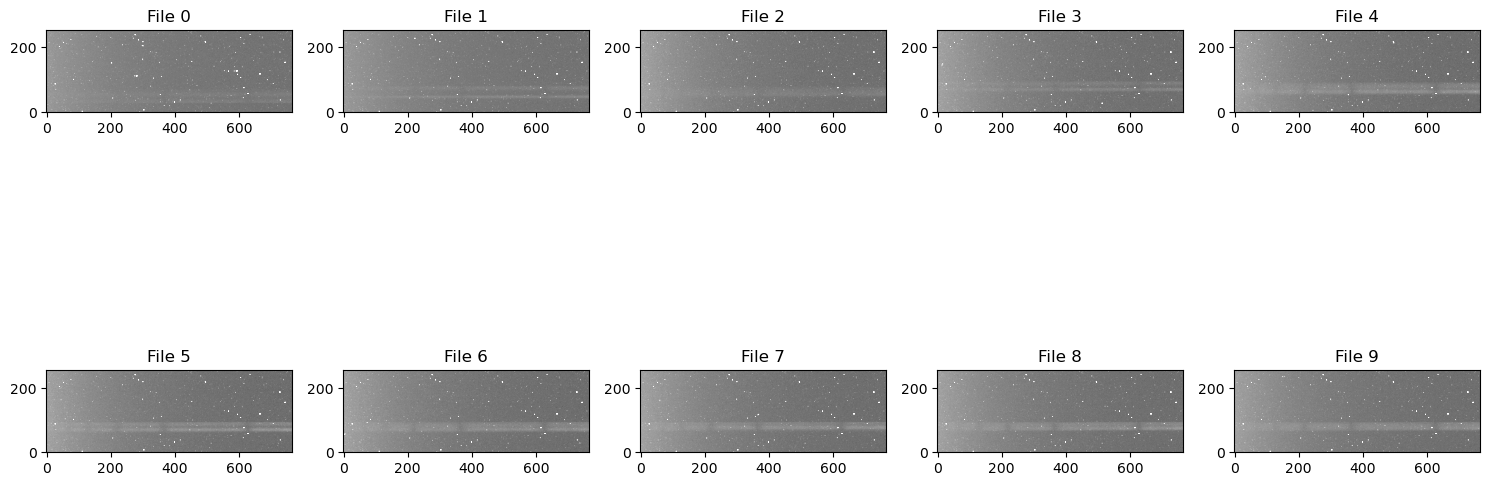

In [34]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau[i],
            vmin=np.mean(raw_20tau[i]) - (2 * np.std(raw_20tau[i])),
            vmax=np.mean(raw_20tau[i]) + (2 * np.std(raw_20tau[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [35]:
# List to hold the cut data of each corrected 20 Tau frame
raw_20tau_cut = []

# Define the y-axis ranges for each frame
y_20tau_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
#     tau20_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_20tau_frame_00{i}.FIT'
#     tau20_corrected_file_data = fits.open(tau20_corrected_file)

#     # Get the full frame data
#     frame_data = tau20_corrected_file_data[0].data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_20tau_ranges[i]
    cut_frame_data = raw_20tau[i][y_start:y_end, :]

    # Append the cut frame data to the list
    raw_20tau_cut.append(cut_frame_data)

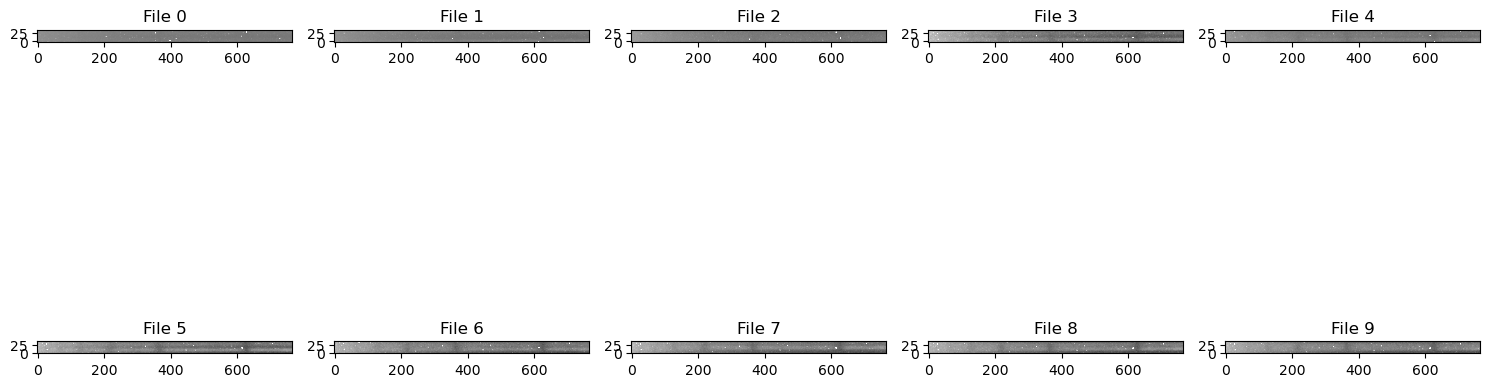

In [36]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau_cut):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau_cut[i],
            vmin=np.mean(raw_20tau_cut[i]) - (2 * np.std(raw_20tau_cut[i])),
            vmax=np.mean(raw_20tau_cut[i]) + (2 * np.std(raw_20tau_cut[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [37]:
darksubtracted_20tau = []
for i in range(10):
    dark_sub=raw_20tau_cut[i]-darks_20tau_cut[i]
    darksubtracted_20tau.append(dark_sub)

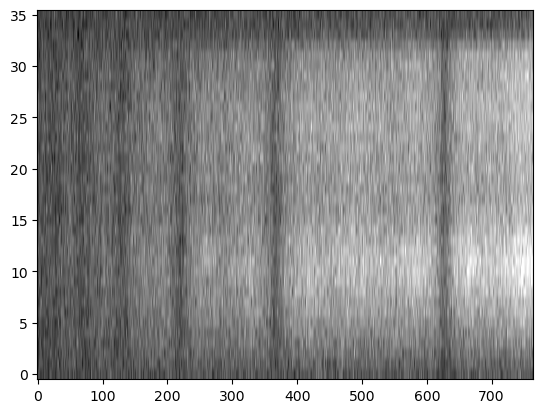

In [38]:
master_20tau = (np.median(darksubtracted_20tau, axis=0))

plt.imshow(master_20tau, cmap='gray',
           vmin=np.mean(master_20tau) - (3 * np.std(master_20tau)),
           vmax=np.mean(master_20tau) + (3 * np.std(master_20tau)), aspect='auto', origin='lower')

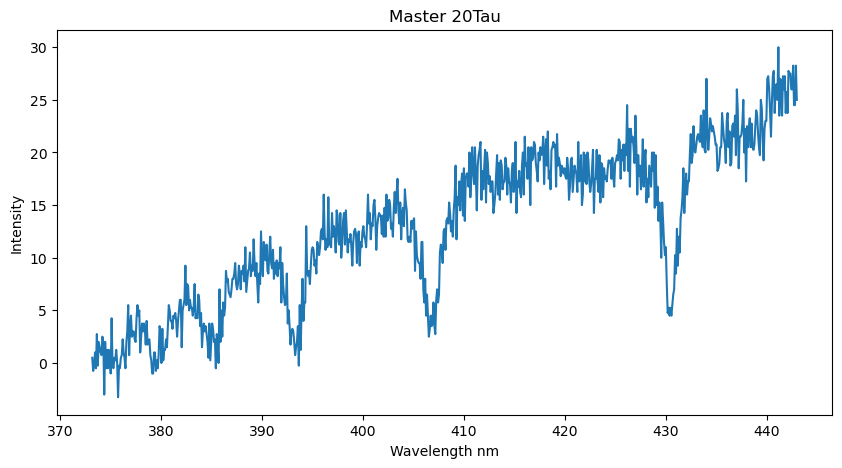

30.0


In [39]:
# Step 1: Sum along the y-axis for each mercury frame
master_20tau_1d= np.median(master_20tau, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_20tau_1d)
plt.title("Master 20Tau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()
print(np.max(master_20tau_1d))

# Reference spectrum of Maia

In [42]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

file_path = f'{ownerpath}/Lab 3/archive/standard_spec.fits'

with fits.open(file_path) as hdul:
    data = hdul[1].data
    wavelength = data['WAVE']  # 波长
    flux = data['FLUX']   

In [43]:
print(data.columns)

ColDefs(
    name = 'WAVE'; format = '189660D'; unit = 'angstrom'
    name = 'FLUX'; format = '189660E'; unit = 'adu'
    name = 'ERR'; format = '189660E'; unit = 'adu'
)


In [46]:
if hasattr(wavelength, 'value'):
    wavelength = wavelength.value
if hasattr(flux, 'value'):
    flux = flux.value

#Make sure it is 1D array
wavelength = wavelength.squeeze()
flux = flux.squeeze()

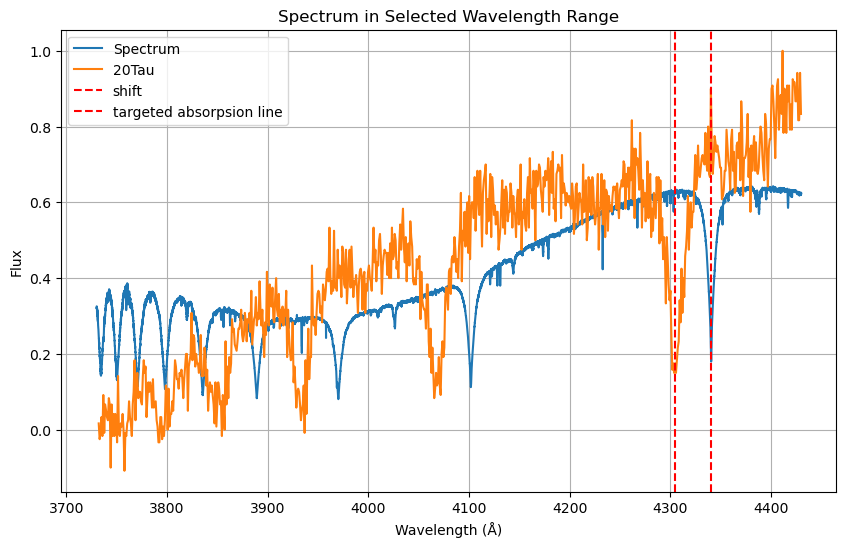

In [47]:
wavelength_range = (wavelength > 3730) & (wavelength < 4430)
selected_wavelength = wavelength[wavelength_range]
selected_flux = flux[wavelength_range]

plt.figure(figsize=(10, 6))
plt.plot(selected_wavelength, selected_flux, label="Spectrum")
plt.plot(calibrated_wave*10,master_20tau_1d/30,label="20Tau")
plt.axvline(4340, color='red', linestyle='--', label='shift')
plt.axvline(4305, color='red', linestyle='--', label='targeted absorpsion line')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Spectrum in Selected Wavelength Range")
plt.legend()
plt.grid(True)
plt.show()

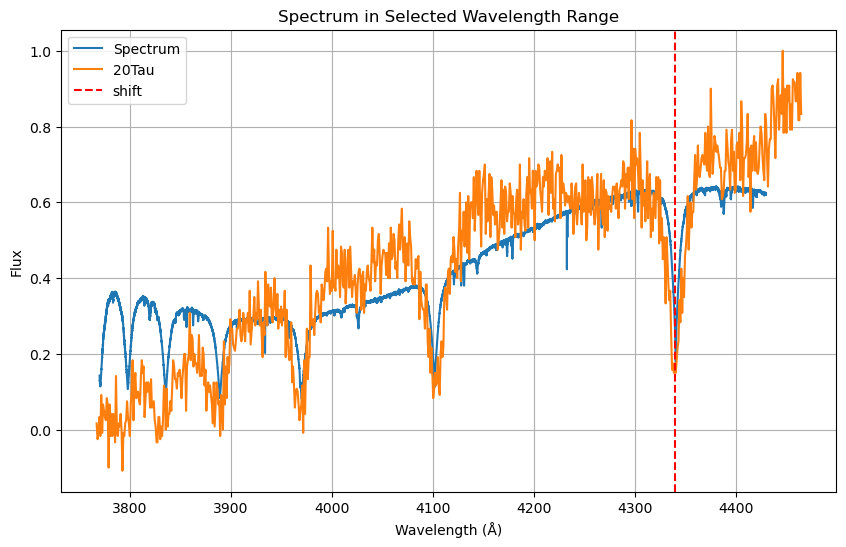

In [49]:
wavelength_range = (wavelength > 3770) & (wavelength < 4430)
selected_wavelength = wavelength[wavelength_range]
selected_flux = flux[wavelength_range]

plt.figure(figsize=(10, 6))
plt.plot(selected_wavelength, selected_flux, label="Spectrum")
plt.plot(calibrated_wave*10+35,master_20tau_1d/30,label="20Tau")
plt.axvline(4340, color='red', linestyle='--', label='shift')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Spectrum in Selected Wavelength Range")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
from astropy.modeling import models
from astropy import units as u
from astropy.coordinates import SkyCoord

from specutils.spectra import Spectrum1D
from astropy.modeling import models, fitting
from specutils.fitting import fit_lines

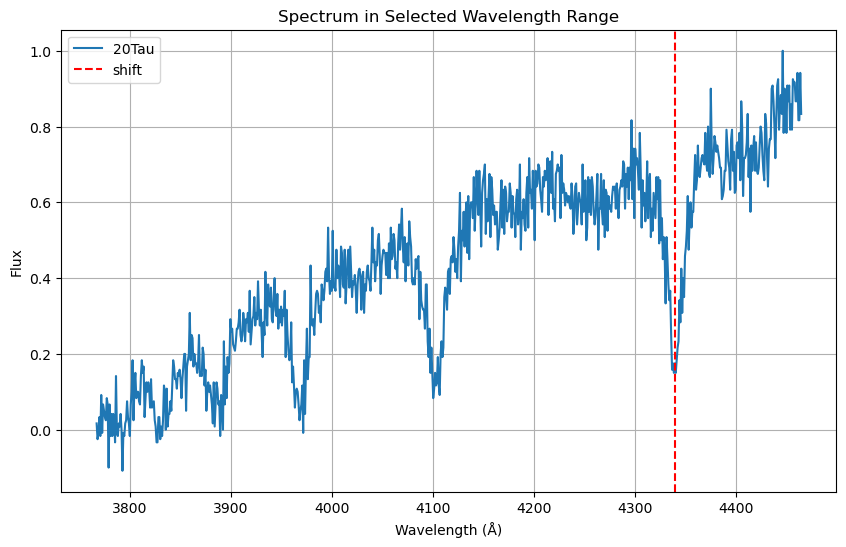

In [84]:
plt.figure(figsize=(10, 6))
#plt.plot(selected_wavelength, selected_flux, label="Spectrum")
plt.plot(calibrated_wave*10+35,master_20tau_1d/30,label="20Tau")
plt.axvline(4340, color='red', linestyle='--', label='shift')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Spectrum in Selected Wavelength Range")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
new_20tau_wave = calibrated_wave * 10 + 35  
new_20tau_flux = master_20tau_1d / 30       

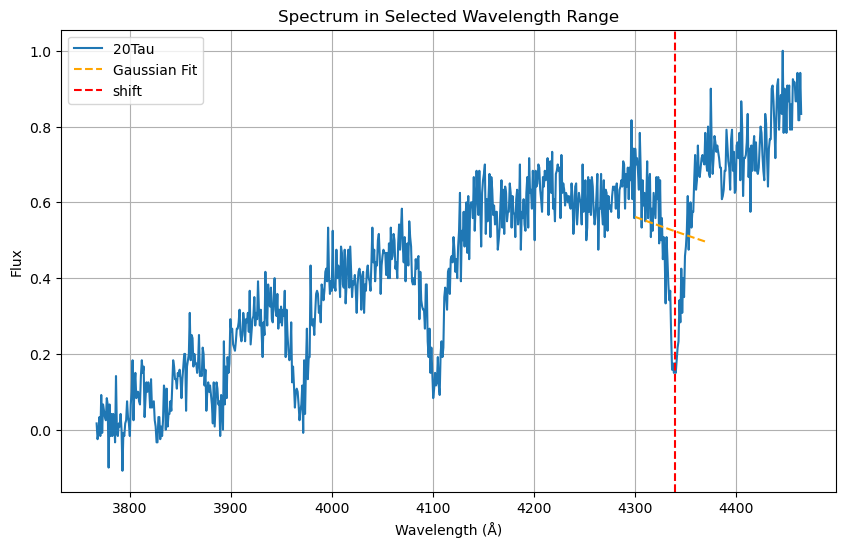

In [94]:
fit_range = (wave > 4300) & (wave < 4370)  # chosen wavelength range
wave_fit = wave[fit_range]
flux_fit = flux[fit_range]

flux_fit = flux_fit * u.Unit("1") 
wave_fit = wave_fit * u.angstrom  

#Gaussion distrubution fitting
x = wave_fit
spectrum = Spectrum1D(flux=flux_fit, spectral_axis=wave_fit)
g_init = models.Gaussian1D(amplitude=0.6, mean=4335, stddev=5)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(x)

plt.figure(figsize=(10, 6))
plt.plot(new_20tau_wave, new_20tau_flux,label="20Tau")
plt.plot(x, y_fit, label="Gaussian Fit", color='orange', linestyle='--')
plt.axvline(4340, color='red', linestyle='--', label='shift')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Spectrum in Selected Wavelength Range")
plt.legend()
plt.grid(True)
plt.show()

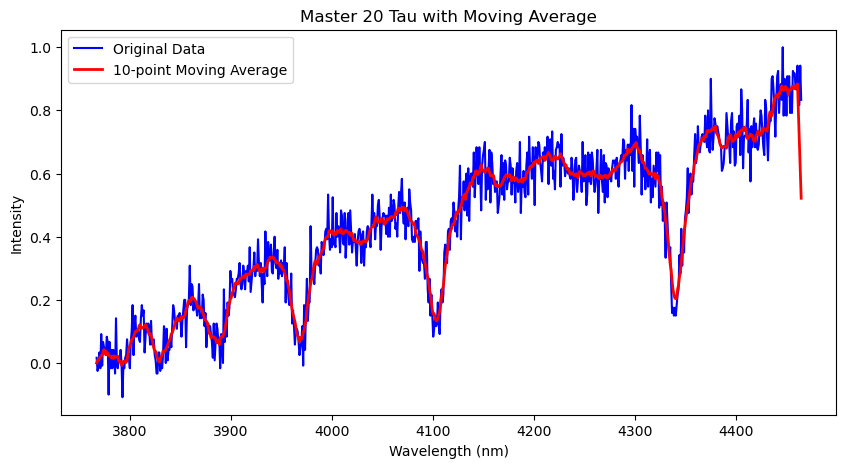

In [109]:
# Define the window size for the moving average
window_size = 10  # You can adjust this depending on how smooth you want the result to be

# Compute the moving average using np.convolve
moving_average_20tau = np.convolve(new_20tau_flux, np.ones(window_size)/window_size, mode='same')

# Plot the original data and the moving average
plt.figure(figsize=(10, 5))

#Shows original data
plt.plot(new_20tau_wave, new_20tau_flux, label='Original Data', color='blue')
plt.plot(new_20tau_wave, moving_average_20tau, label=f'{window_size}-point Moving Average', color='red', linewidth=2)
plt.title("Master 20 Tau with Moving Average")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

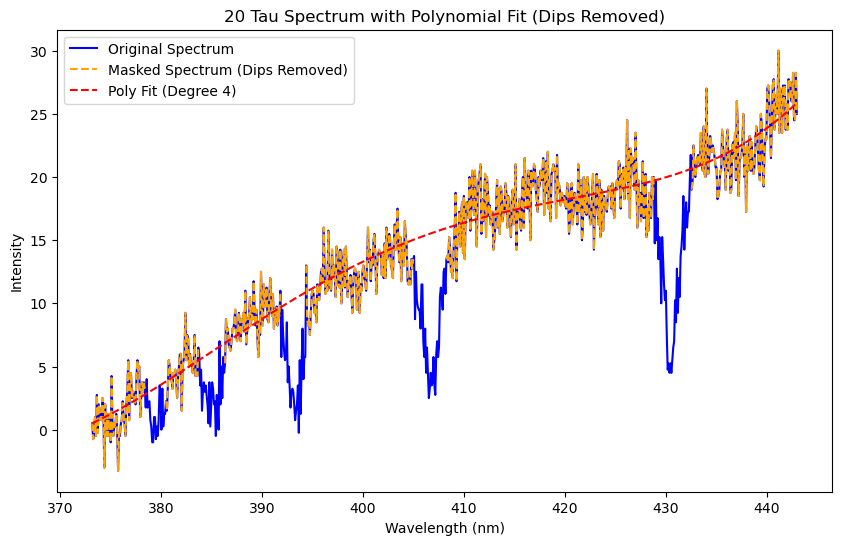

In [113]:
# Example data (replace with your actual data)
# calibrated_wave = np.array([...])  # Your wavelength data
# master_etatau_1d = np.array([...])  # Your intensity data

# Define the dip ranges
dip_ranges = [(378.5, 380.5), (383.8, 386.3), (391.9, 394.35), (405, 408.2), (428.9, 432.5)]

# Function to mask known emission dips by wavelength range
def mask_known_emission_dips(wavelength, intensity, dip_ranges):
    """
    Masks known emission dips by wavelength range.

    Parameters:
        wavelength: Array of wavelengths (nm)
        intensity: Array of intensity values
        dip_ranges: List of tuples defining wavelength ranges to mask (e.g., [(430, 440), (410, 420)])

    Returns:
        masked_intensity: The intensity array with known emission dips masked
        mask: A boolean array where True represents a masked region
    """
    mask = np.zeros_like(intensity, dtype=bool)
    masked_intensity = np.copy(intensity)

    for (start, end) in dip_ranges:
        # Identify indices that fall within each dip range
        dip_mask = (wavelength >= start) & (wavelength <= end)
        mask[dip_mask] = True
        masked_intensity[dip_mask] = np.nan  # Mask out by setting the intensity to NaN

    return masked_intensity, mask

# Step 1: Mask known emission dips
masked_intensity, mask_known = mask_known_emission_dips(calibrated_wave, master_20tau_1d, dip_ranges)

# Step 2: Fit a polynomial to the remaining (non-masked) data
# We will fit a 3rd degree polynomial to the non-masked intensity data

# Get the non-masked (valid) data points
valid_wavelengths = calibrated_wave[~mask_known]
valid_intensities = masked_intensity[~mask_known]

# Fit a polynomial (degree 3 in this case)
degree = 4
poly_coeffs = np.polyfit(valid_wavelengths, valid_intensities, degree)
poly_fit_20tau = np.polyval(poly_coeffs, calibrated_wave)

# Step 3: Plot the original spectrum, the masked spectrum, and the polynomial fit
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave, master_20tau_1d, label='Original Spectrum', color='blue')
plt.plot(calibrated_wave, masked_intensity, label='Masked Spectrum (Dips Removed)', color='orange', linestyle='--')
plt.plot(calibrated_wave, poly_fit_20tau, label=f'Poly Fit (Degree {degree})', color='red', linestyle='--')
plt.title("20 Tau Spectrum with Polynomial Fit (Dips Removed)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [110]:
# Constants
h = 6.62607015e-34  # Planck's constant (J·s)
c = 3.0e8           # Speed of light (m/s)
k_B = 1.380649e-23  # Boltzmann constant (J/K)

# Define Planck's law for blackbody radiation
def blackbody_spectrum(wavelength, T):
    """Planck's law for blackbody radiation in terms of wavelength."""
    wavelength_m = wavelength * 1e-9  # Convert from nm to m
    B_lambda = (2 * h * c**2) / (wavelength_m**5) * (1 / (np.exp((h * c) / (wavelength_m * k_B * T)) - 1))
    return B_lambda

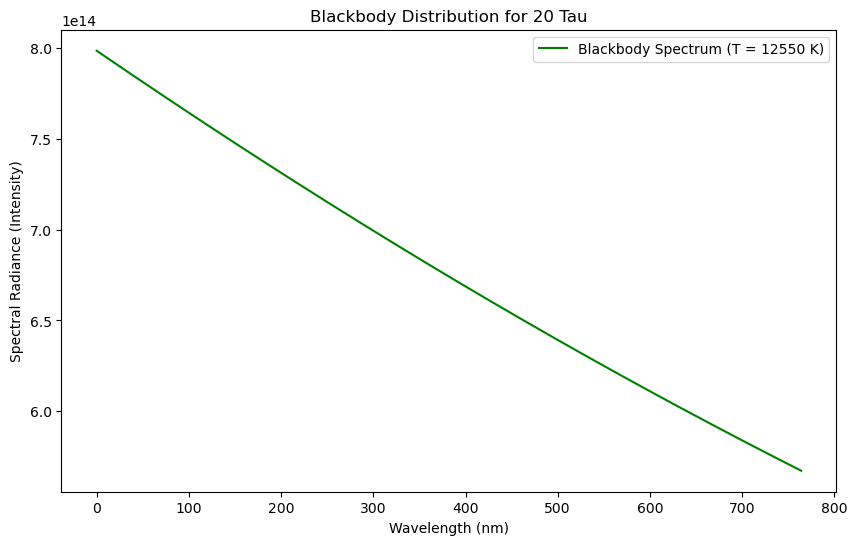

In [111]:
# Given temperature of 20 Tau
Temp_20_tau = 12550  # K

# Step 1: Generate the blackbody spectrum for 20 Tau
bb_spectrum_20tau = blackbody_spectrum(calibrated_wave, Temp_20_tau)

# Step 2: Plot the blackbody spectrum
plt.figure(figsize=(10, 6))
plt.plot(bb_spectrum_20tau, label=f'Blackbody Spectrum (T = {Temp_20_tau} K)', color='green')
plt.title("Blackbody Distribution for 20 Tau")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Radiance (Intensity)")
plt.legend()
plt.show()

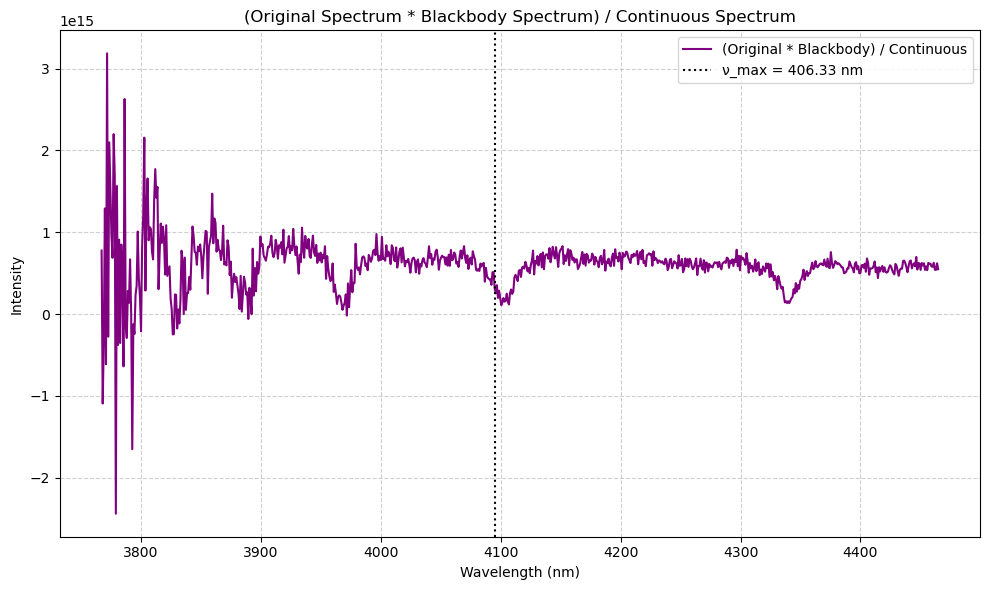

In [115]:
# Calculate the Result: (Original Spectrum * Blackbody Spectrum) / Continuum Spectrum
result_20tau = (master_20tau_1d * bb_spectrum_20tau) / poly_fit_20tau

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(new_20tau_wave, result_20tau, label="(Original * Blackbody) / Continuous", color='purple')
plt.title("(Original Spectrum * Blackbody Spectrum) / Continuous Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.grid(True, linestyle='--', alpha=0.6)
# Add a vertical dotted line at 406.33 nm
plt.axvline(x=406.01*10+35, color='black', linestyle=':', label='ν_max = 406.33 nm')
plt.legend()
plt.tight_layout()
plt.show()

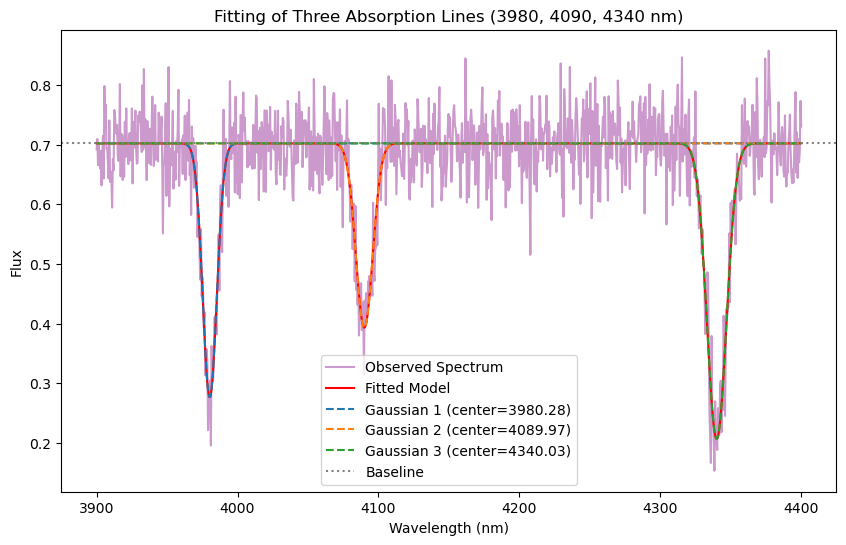

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Difine the multiple Gaussion model
def multi_gaussian(x, *params):
    n = (len(params) - 1) // 3  #Each Gaussion has 3 parameters and the last one is baseline
    baseline = params[-1]
    y = np.zeros_like(x) + baseline
    for i in range(n):
        A = params[3 * i]
        x0 = params[3 * i + 1]
        sigma = params[3 * i + 2]
        y += A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

wavelength = np.linspace(3900, 4400, 1000) 
baseline = 0.7  
flux = baseline - (
    0.4 * np.exp(-(wavelength - 3980)**2 / (2 * 5**2)) +
    0.3 * np.exp(-(wavelength - 4090)**2 / (2 * 6**2)) +
    0.5 * np.exp(-(wavelength - 4340)**2 / (2 * 7**2))
) + 0.05 * np.random.normal(size=len(wavelength))  

p0 = [
    0.4, 3980, 5,  
    0.3, 4090, 6, 
    0.5, 4340, 7, 
    0.7]

popt, pcov = curve_fit(multi_gaussian, wavelength, flux, p0=p0)

plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Observed Spectrum', color='purple', alpha=0.4)  
plt.plot(wavelength, multi_gaussian(wavelength, *popt), label='Fitted Model', color='red')  
for i in range((len(popt) - 1) // 3):
    A, x0, sigma = popt[3 * i:3 * i + 3]
    plt.plot(wavelength, A * np.exp(-(wavelength - x0)**2 / (2 * sigma**2)) + popt[-1],
             linestyle='--', label=f'Gaussian {i + 1} (center={x0:.2f})')
plt.axhline(popt[-1], color='gray', linestyle=':', label='Baseline')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
plt.title('Fitting of Three Absorption Lines (3980, 4090, 4340 nm)')
plt.show()